In [1]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [5]:
# Optimize
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers, callbacks
#data augmentation
data_augmentation = tf.keras.Sequential([

    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])


In [7]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def build_simple_cnn():
  model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
  return model


In [8]:


simple_cnn = build_simple_cnn()
simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

simple_cnn_history = simple_cnn.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stop])


Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.7961 - loss: 0.6811 - val_accuracy: 0.9360 - val_loss: 0.2747
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9374 - loss: 0.2765 - val_accuracy: 0.9377 - val_loss: 0.2520
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.9492 - loss: 0.2411 - val_accuracy: 0.9283 - val_loss: 0.3029
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9562 - loss: 0.2156 - val_accuracy: 0.9206 - val_loss: 0.2972


In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs = simple_cnn.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step


In [10]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


Accuracy: 94.20%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.94      0.94       293
   PNEUMONIA       0.94      0.95      0.94       293

    accuracy                           0.94       586
   macro avg       0.94      0.94      0.94       586
weighted avg       0.94      0.94      0.94       586



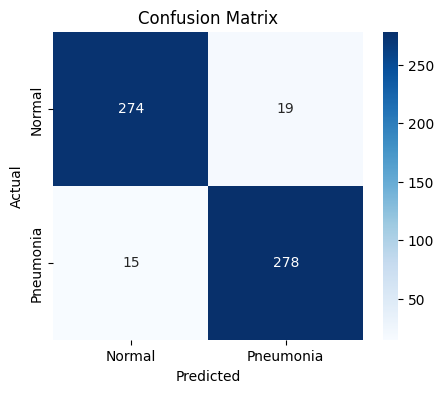

In [11]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.9848


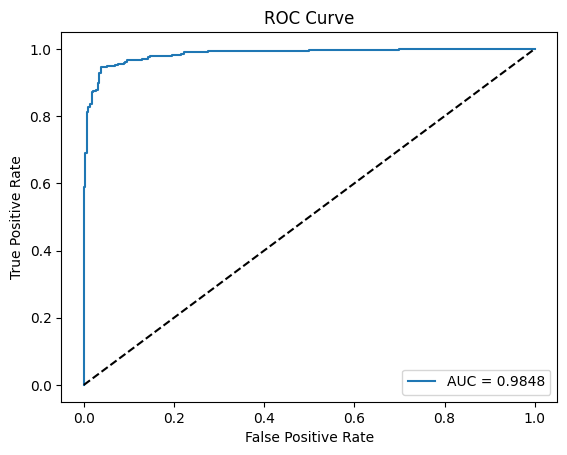

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
